In [329]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import cross_val_score

In [330]:
df = pd.read_csv("Fraud.csv")

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [332]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [333]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Type of Transaction 

In [334]:
df.type.unique() # All types of transactions in dataset

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [335]:
df[df["isFraud"] == 1].type.unique()
# Fraud is only seen in these two types on transactions. 

array(['TRANSFER', 'CASH_OUT'], dtype=object)

Text(0.5, 1.0, 'Number of Frauds with these 2 type of Transaction')

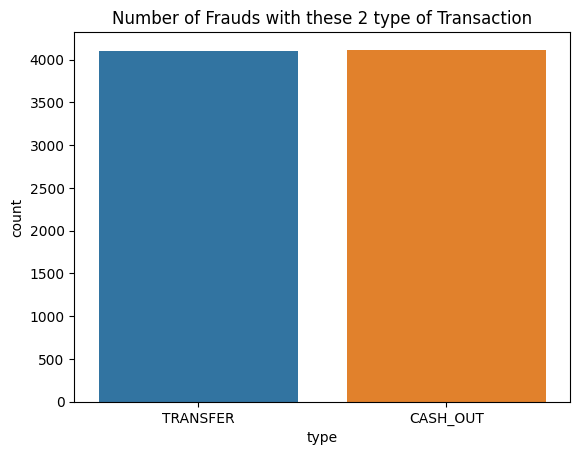

In [336]:
sns.countplot(x=df[df["isFraud"] == 1].type)
plt.title("Number of Frauds with these 2 type of Transaction")

In [337]:
# We saw that all fraudulent transactions are either Transfer or Cash-Out, 
# but all Transfer and Cash Out need not be fraudulent. Let's see the count.  

In [338]:
df[df["type"] == "TRANSFER"].isFraud.value_counts()

0    528812
1      4097
Name: isFraud, dtype: int64

In [339]:
df[df["type"] == "CASH_OUT"].isFraud.value_counts()

0    2233384
1       4116
Name: isFraud, dtype: int64

In [340]:
# Insight: Type is a good indicator of Fraudulent Transaction and it has to be included in model.

# Transacted Amount 

(0.0, 6000000.0)

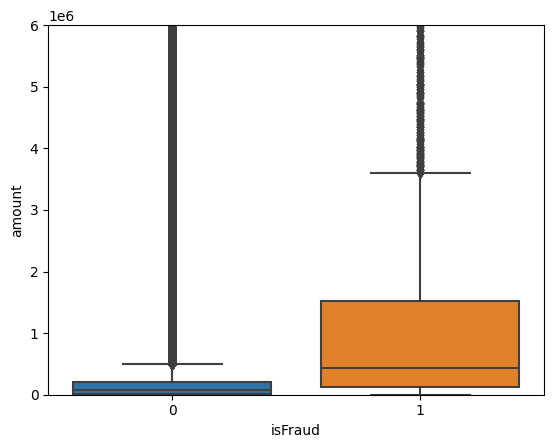

In [341]:
sns.boxplot(y=df.amount, x=df.isFraud)
plt.ylim(0, 6000000)

In [342]:
print("Fraudulent Cases:-")
print(f"\tMax Amount: {df[df.isFraud == 1].amount.max()}")
print(f"\tMean Amount: {df[df.isFraud == 1].amount.mean()}") 
print(f"\tMin Amount: {df[df.isFraud == 1].amount.min()}")
print("\n\nGenuine Cases:-")
print(f"\tMax Amount: {df[df.isFraud == 0].amount.max()}")
print(f"\tMean Amount: {df[df.isFraud == 0].amount.mean()}") 
print(f"\tMin Amount: {df[df.isFraud == 0].amount.min()}")

Fraudulent Cases:-
	Max Amount: 10000000.0
	Mean Amount: 1467967.299140387
	Min Amount: 0.0


Genuine Cases:-
	Max Amount: 92445516.64
	Mean Amount: 178197.04172740763
	Min Amount: 0.01


Text(0.5, 1.0, 'Distribution of Transacted Amount')

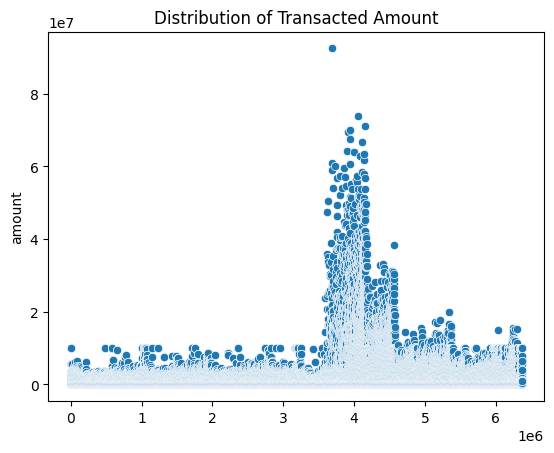

In [343]:
sns.scatterplot(x=df.index, y=df.amount, alpha=1)
plt.title("Distribution of Transacted Amount")

In [344]:
df[df["amount"] > 3500000].isFraud.value_counts()

0    16957
1     1033
Name: isFraud, dtype: int64

# Origin and Destination Name

In [345]:
df.nameOrig.nunique()

6353307

In [346]:
df.nameOrig.apply(lambda x: x[0]).value_counts() # All are done by Customers, so this variable can be removed.

C    6362620
Name: nameOrig, dtype: int64

In [347]:
df.nameDest.apply(lambda x: x[0]).value_counts()

C    4211125
M    2151495
Name: nameDest, dtype: int64

In [348]:
# The ID is not so important but Customer or Merchant maybe a good indicator!

(0.0, 200000.0)

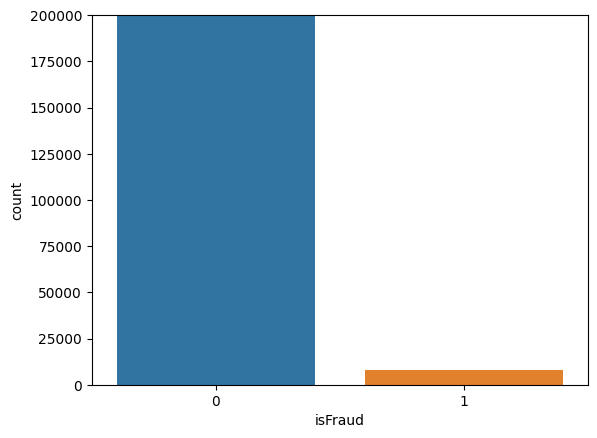

In [349]:
sns.countplot(x=df[df["nameDest"].str.startswith("C")]["isFraud"])
plt.ylim(0,200000)

<Axes: xlabel='isFraud', ylabel='count'>

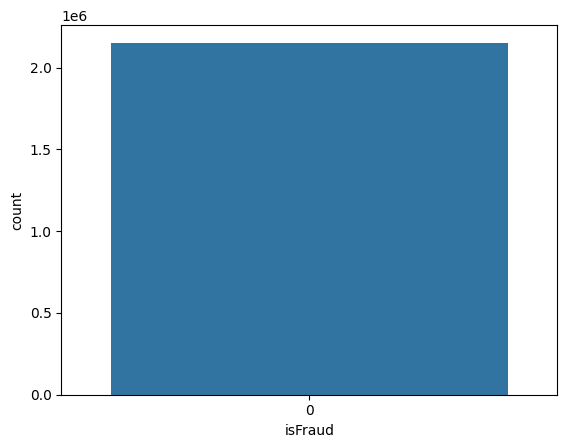

In [350]:
sns.countplot(x=df[df["nameDest"].str.startswith("M")]["isFraud"])

In [351]:
# Customer to Customer Transactions can be fraudulent but not customer to merchant (Based on dataset)

In [352]:
df.nameDest = df.nameDest.apply(lambda x: 0 if x[0] == "C" else 1) 

In [353]:
df = df.rename(columns={"nameDest" : "Destination C/M"})

# Old/New Balance

In [354]:
df[df.newbalanceOrig < 1].isFraud.value_counts()

0    3601529
1       8053
Name: isFraud, dtype: int64

In [355]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [356]:
print(f"In {int((8053/8213)* 100)}% of the cases, Amount left in the bank is 0")

In 98% of the cases, Amount left in the bank is 0


In [357]:
# This is a very important Indicator to identify Fraudulent cases.

In [358]:
df[df.oldbalanceDest < 1].isFraud.value_counts()

0    2699043
1       5351
Name: isFraud, dtype: int64

In [359]:
# Also a good indicator!

In [360]:
df[df.newbalanceDest <100000].isFraud.value_counts()

0    2780135
1       4436
Name: isFraud, dtype: int64

# Old fraud detection model


In [361]:
print(classification_report(df.isFraud, df.isFlaggedFraud))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       1.00      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       1.00      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620



In [362]:
print(confusion_matrix(y_true=df.isFraud, y_pred=df.isFlaggedFraud))

[[6354407       0]
 [   8197      16]]


In [363]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [364]:
df[df["isFlaggedFraud"] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,Destination C/M,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,0,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,0,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,0,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,0,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,0,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,0,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,0,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,0,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,0,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,0,0.0,0.0,1,1


In [365]:
df[df["newbalanceDest"] == 0].isFraud.value_counts()

0    2435342
1       4091
Name: isFraud, dtype: int64

In [366]:
df[df["type"] == "CASH_OUT"].isFlaggedFraud.value_counts()

0    2237500
Name: isFlaggedFraud, dtype: int64

In [367]:
# IMPORTANT: The current model doesn't focus on cash out transactions! 
# As the model fails to detect any fraud on cash-out type transactions.

In [368]:
# Features to be included: [type, amount, nameDest, newbalanceOrig, oldbalanceDest, newbalanceDest]

# Pre-Processing

In [369]:
df = pd.concat([df, pd.get_dummies(df.type)], axis=1).drop("type", axis=1)

In [370]:
# genuine = df[df['isFraud'] == 0].sample(n=20000)
# fraud = df[df["isFraud"] == 1 ]

# df = pd.concat([genuine, fraud])
# df = df.sample(frac=1)

In [371]:
len(df)

6362620

In [372]:
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,Destination C/M,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,1,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,1,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,0,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,0,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,1,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,0,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,0,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,0,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,0,0.00,0.00,1,0,0,0,0,0,1


In [374]:
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,Destination C/M,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,1,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,1,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,0,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,0,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,1,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,0,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,0,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,0,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,0,0.00,0.00,1,0,0,0,0,0,1


In [375]:
X = df.drop(["isFraud", "isFlaggedFraud", "step", "nameOrig"], axis=1)
y = df["isFraud"]

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [377]:
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'Destination C/M',
       'oldbalanceDest', 'newbalanceDest']


In [378]:
X_train

,amount,oldbalanceOrg,newbalanceOrig,Destination C/M,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
2026075,1841222.45,72884.00,0.00,0,69271.33,1910493.78,0,0,0,0,1
6102952,350817.44,0.00,0.00,0,995120.10,1345937.54,0,1,0,0,0
5568275,240747.97,49674.00,0.00,0,1112514.03,1353262.01,0,1,0,0,0
192521,22973.63,15306.00,0.00,1,0.00,0.00,0,0,0,1,0
958441,15060.14,488.00,0.00,1,0.00,0.00,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5981007,3600.64,113140.00,109539.36,1,0.00,0.00,0,0,0,1,0
4071444,134373.68,1428910.04,1563283.72,0,1305257.21,1170883.54,1,0,0,0,0
3220254,234791.25,95028.00,0.00,0,548403.40,783194.65,0,1,0,0,0
4219806,165088.16,0.00,0.00,0,2632503.75,2797591.91,0,1,0,0,0


In [379]:
scaler = StandardScaler()
# X_train[num_cols] = pd.DataFrame(scaler.fit_transform(X_train[num_cols]))
# X_test[num_cols] = pd.DataFrame(scaler.transform(X_test[num_cols]))

In [380]:
num_cols

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'Destination C/M',
 'oldbalanceDest',
 'newbalanceDest']

In [381]:
ct = ColumnTransformer([
    ("scaler", StandardScaler(), num_cols)
],remainder="passthrough" )

In [382]:
X_train = pd.DataFrame(ct.fit_transform(X_train), columns= X_train.columns)

In [383]:
X_test = pd.DataFrame(ct.transform(X_test), columns= X_test.columns)

# Model making!

In [384]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [385]:
lrPred = LR.predict(X_test) 

In [386]:
print(classification_report(y_test, lrPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.94      0.41      0.58       821

    accuracy                           1.00    636262
   macro avg       0.97      0.71      0.79    636262
weighted avg       1.00      1.00      1.00    636262



In [387]:
print(confusion_matrix(y_test, lrPred))

[[635421     20]
 [   481    340]]


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

In [ ]:
rfPred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test, rfPred))

In [321]:
rf_cross_val = cross_val_score(rf, X_train, y_train,cv=10 )

In [328]:
print(rf_cross_val)
print(f"Mean: {rf_cross_val.mean()}")
print(f"Standard Deviation: {np.sqrt(rf_cross_val.var())}")

[0.99468321 0.99335401 0.99335401 0.99202481 0.99778467 0.99246788
 0.99468321 0.99069561 0.99158175 0.99335401]
Mean: 0.993398316349136
Standard Deviation: 0.001894851996485881


In [315]:
svmModel = SVC()
svmModel.fit(X_train, y_train)

SVC()

In [316]:
svmPred = svmModel.predict(X_test)

In [317]:
print(classification_report(y_test, svmPred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4000
           1       0.96      0.78      0.86      1643

    accuracy                           0.93      5643
   macro avg       0.94      0.89      0.91      5643
weighted avg       0.93      0.93      0.93      5643



In [318]:
print(confusion_matrix(y_test, svmPred))

[[3947   53]
 [ 354 1289]]


In [319]:
list(zip(list(X_train.columns),sorted(rf.feature_importances_, reverse=True)))

[('amount', 0.2890641344232403),
 ('oldbalanceOrg', 0.22121229148784669),
 ('newbalanceOrig', 0.12469401945014642),
 ('Destination C/M', 0.10016540759891457),
 ('oldbalanceDest', 0.09399230631814914),
 ('newbalanceDest', 0.054651698601573706),
 ('CASH_IN', 0.03386729587089053),
 ('CASH_OUT', 0.03128333090484758),
 ('DEBIT', 0.029731890824605763),
 ('PAYMENT', 0.020924177014942768),
 ('TRANSFER', 0.0004134475048425662)]

In [80]:
X_train = X_train.drop(8, axis=1)

In [81]:
X_test = X_test.drop(8, axis=1)